In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import edhec_risk_ph as erk
%load_ext autoreload
%autoreload 2

In [2]:
def inst_to_ann(r):
    """Convert an instantaneous return to an annualized return."""
    return np.expm1(r)

def ann_to_inst(r):
    """Convert an annualized return to an instantaneous return."""
    return np.log1p(r)  


In [3]:
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r0=None):
    """Simulate interest rates using the CIR model."""
    
    if r0 is None:
        r0 = b

    r0 = ann_to_inst(r0)
    
    
    
    dt = 1/steps_per_year
    num_steps = int(n_years * steps_per_year)+1
    shock = np.random.normal(0, np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.zeros_like(shock)
    rates[0] = r0
    for t in range(1, num_steps):
        dr = a * (b - rates[t-1]) * dt + sigma * np.sqrt(np.maximum(rates[t-1], 0)) * shock[t]
        rates[t] = abs(rates[t-1] + dr) # ensure rates stay non-negative

    return pd.DataFrame(inst_to_ann(rates), 
                        index = range(num_steps))


In [4]:
def show_cir_simulation(n_years=10, n_scenarios=5, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r0=None):
    """Simulate and plot interest rates using the CIR model."""
    cir(n_years=n_years, n_scenarios=n_scenarios, a=a, b=b, sigma=sigma, steps_per_year=steps_per_year, r0=r0).plot(legend=False,
                                                                                                                    title='CIR Model Interest Rate Simulation',
                                                                                                                    figsize=(10,6))

import ipywidgets as widgets
from IPython.display import display

controls = widgets.interactive(show_cir_simulation,
                              n_years=widgets.IntSlider(value=10, min=1, max=30, step=1, description='Years'),
                              n_scenarios=widgets.IntSlider(value=5, min=1, max=20, step=1, description='Scenarios'),
                              a=widgets.FloatSlider(value=0.05, min=0.01, max=0.2, step=0.01, description='Mean Reversion Speed (a)'),
                              b=widgets.FloatSlider(value=0.03, min=0.0, max=0.1, step=0.005, description='Long-term Mean (b)'),
                                sigma=widgets.FloatSlider(value=0.05, min=0.01, max=0.2, step=0.01, description='Volatility (σ)'),
                                r0=widgets.FloatSlider(value=0.03, min=0.0, max=0.1, step=0.005, description='Initial Rate (r0)'))
display(controls)

interactive(children=(IntSlider(value=10, description='Years', max=30, min=1), IntSlider(value=5, description=…

In [5]:
cir()

,0
0,0.030000
1,0.032623
2,0.033771
3,0.035424
4,0.035064
...,...
116,0.017133
117,0.017580
118,0.015984
119,0.014679


In [5]:
a_0 = 0.75
rates, bond_prices = erk.cir(n_years=10, n_scenarios=10, a=a_0, b=0.03, sigma=0.05, steps_per_year=12, r_0=0.03)
liabilities = bond_prices
zcbond_10 = pd.Series(data=[1], index=[10])
# Calculate zc_0 for each scenario using the initial rate
zc_0 = erk.pv(zcbond_10, r=rates.iloc[0])
n_bonds = a_0 / zc_0
av_zc = n_bonds * bond_prices
av_cash = a_0*(rates/12+1).cumprod()

<Axes: title={'center': 'Asset Value: Cash Strategy vs. ZC Bond Strategy'}>

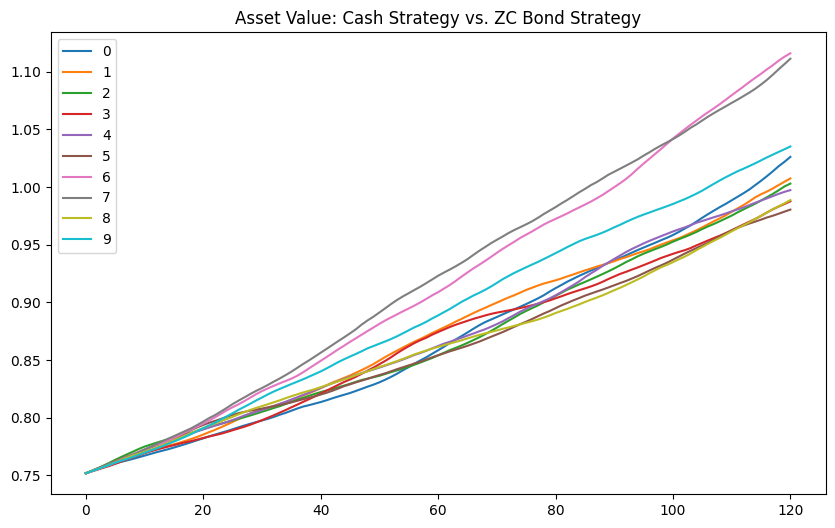

In [6]:
av_cash.plot(title='Asset Value: Cash Strategy vs. ZC Bond Strategy', figsize=(10,6))

<Axes: title={'center': 'Asset Value: Cash Strategy vs. ZC Bond Strategy'}>

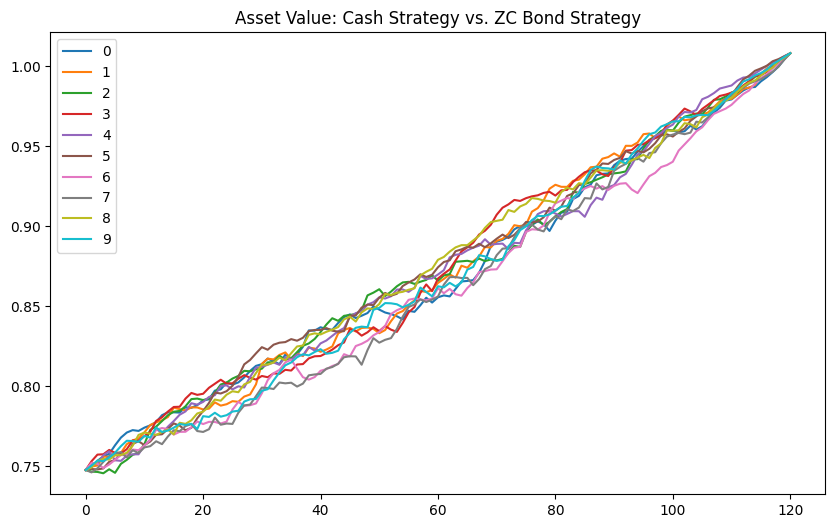

In [7]:
av_zc.plot(title='Asset Value: Cash Strategy vs. ZC Bond Strategy', figsize=(10,6))

<Axes: title={'center': 'Funding Ratio: Cash Strategy vs. ZC Bond Strategy'}>

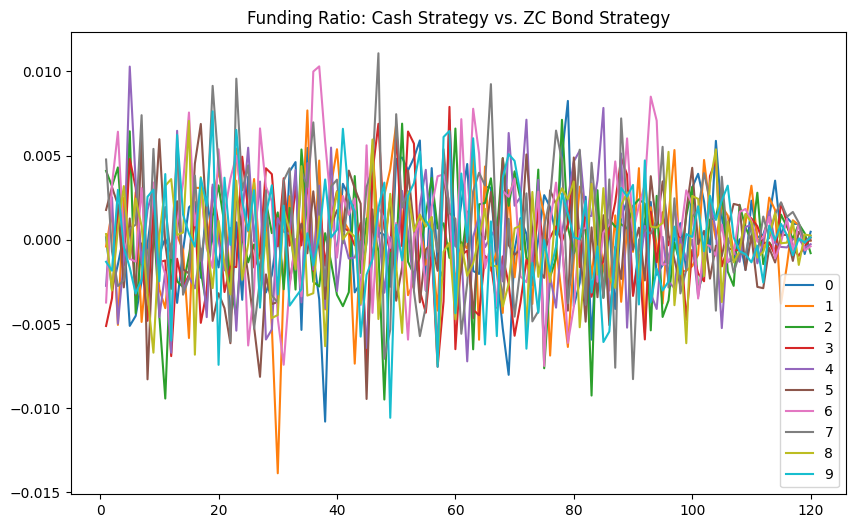

In [8]:
(av_cash/liabilities).pct_change().plot(title='Funding Ratio: Cash Strategy vs. ZC Bond Strategy', figsize=(10,6))

<Axes: title={'center': 'Funding Ratio: Cash Strategy vs. ZC Bond Strategy'}>

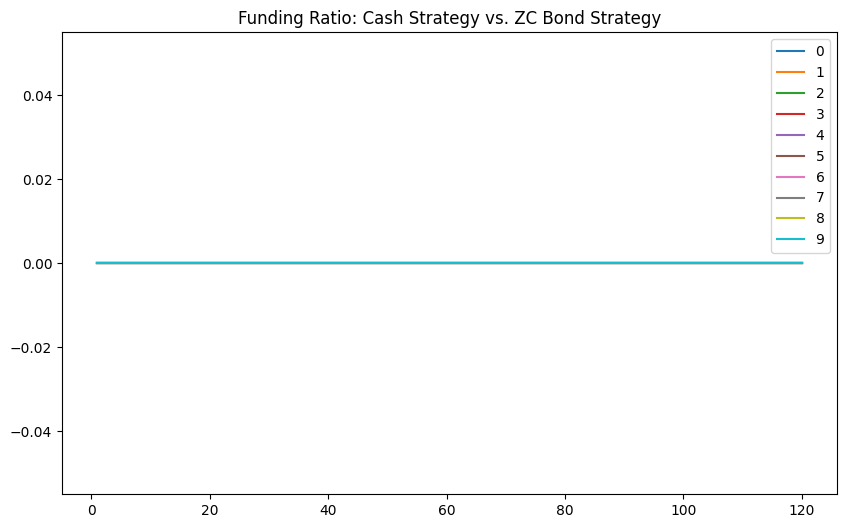

In [9]:
(av_zc/liabilities).pct_change().plot(title='Funding Ratio: Cash Strategy vs. ZC Bond Strategy', figsize=(10,6))

In [10]:
a_0 = 0.5 # reduced initial asset value to see more failures
rates, bond_prices = erk.cir(n_years=10, n_scenarios=10000, a=a_0, b=0.03, sigma=0.10, steps_per_year=12, r_0=0.03)
liabilities = bond_prices
zcbond_10 = pd.Series(data=[1], index=[10])
# Calculate zc_0 for each scenario using the initial rate
zc_0 = erk.pv(zcbond_10, r=rates.iloc[0])
n_bonds = a_0 / zc_0
av_zc = n_bonds * bond_prices
av_cash = a_0*(rates/12+1).cumprod()

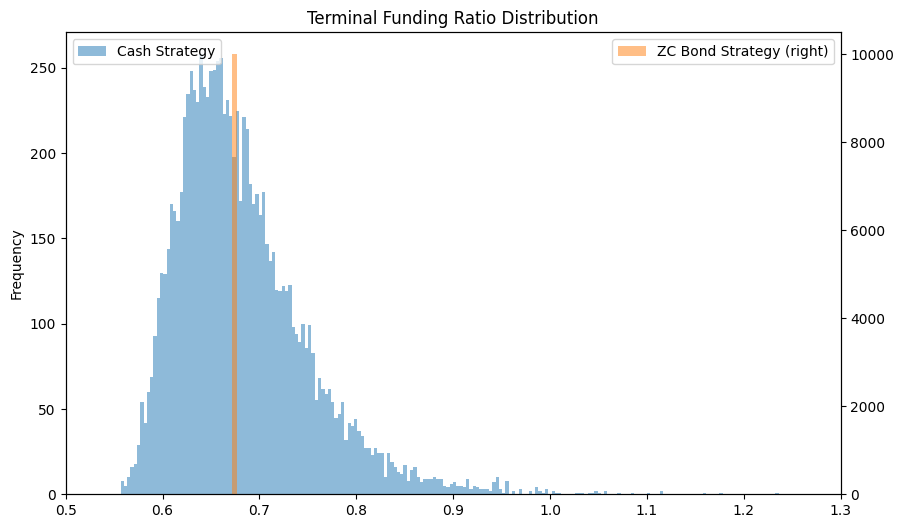

In [11]:

tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc = av_zc.iloc[-1]/liabilities.iloc[-1]
ax1 = tfr_cash.plot(kind='hist', bins=200, alpha=0.5, label='Cash Strategy', title='Terminal Funding Ratio Distribution', figsize=(10,6))
ax2 = tfr_zc.plot(kind='hist', bins=200, alpha=0.5, label='ZC Bond Strategy', secondary_y=True)
ax1.set_xlim(0.5, 1.3)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')